# 10-5. 프로젝트: 개선된 U-Net 모델 만들기
U-Net으로 도로 시맨틱 세그멘테이션을 진행해봤다.   

2018년에 U-Net++ 논문이 나왔다. 기존 U-Net 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델이다. 그리고 논문은 2020년에 한 번 업그레이드 되었다.

- [U-Net++: v1](https://arxiv.org/abs/1807.10165)
- [U-Net++: v2](https://arxiv.org/abs/1912.05074)
- [U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus/tree/master/keras)

Semantic Segmenation을 이용해서 자율주행 차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보자.   
U-Net을 개선해서 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어보자.

# 1. KITTI 데이터셋 수집, 구축

In [17]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

augmentation을 만든 후 데이터가 잘 파싱되어 나오는지 확인해보자.

In [18]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
                        HorizontalFlip(p=0.5),
                        RandomSizedCrop(
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                        ),
                        Resize(width=224,height=224)
                        ])
    return Compose([
                    Resize(width=224, height=224)
                    ])

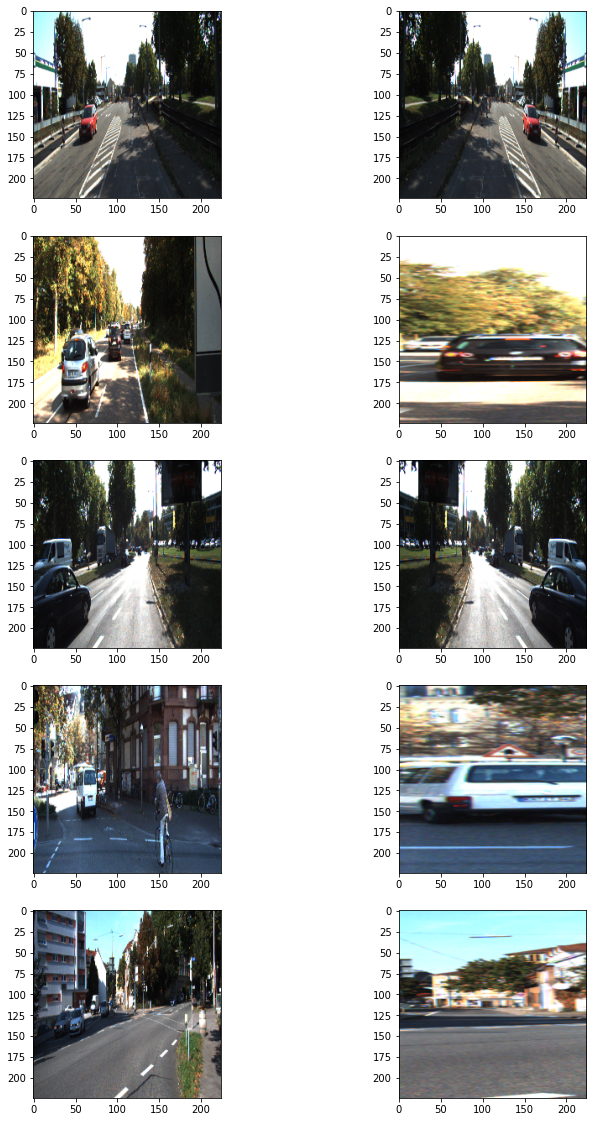

In [19]:
dir_path = "/content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/training"

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"]) # 좌측 원본
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"]) # 우측 augment

plt.show()

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성하자.

In [20]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        # load_dataset()을 통해 kitti dataset의 directory path에서 라벨의 이미지를 확인한다.
        self.data = self.load_dataset()
    
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[:-30]

    def __len__(self):
        # generator의 length, 전체 dataset을 batch_size로 나누고 소숫점 첫째에서 올림한 값 반환한다.
        return math.ceil(len(self.data)/self.batch_size)

    # 입출력 만들기
    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:
                               (index+1)*self.batch_size]
        # 입력은 resize, augment 적용된 input image, 출력은 semenatic label
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
    
    # 1 epoch가 끝나면 실행되는 함수이다.
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [21]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    batch_size=4, # 16 -> 4로 배치 사이즈 변경
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    batch_size=4, # 16 -> 4로 배치 사이즈 변경
    augmentation=test_preproc,
    is_train=False
)

# 2. U-Net++ 모델 구현
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)

In [22]:
def build_unet_pp_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # backbone
    # X_0_0
    backbone_conv_0 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(inputs)
    # backbone_conv_0 = Dropout(0.5)(backbone_conv_0)
    backbone_conv_0 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_conv_0)
    # backbone_conv_0 = Dropout(0.5)(backbone_conv_0)
    backbone_0 = MaxPooling2D(pool_size=2)(backbone_conv_0)

    # X_1_0
    backbone_conv_1 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_0)
    # backbone_conv_1 = Dropout(0.5)(backbone_conv_1)
    backbone_conv_1 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_conv_1)
    # backbone_conv_1 = Dropout(0.5)(backbone_conv_1)
    backbone_1 = MaxPooling2D(pool_size=2)(backbone_conv_1)

    # X_2_0
    backbone_conv_2 = Conv2D(256, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_1)
    # backbone_conv_2 = Dropout(0.5)(backbone_conv_2)
    backbone_conv_2 = Conv2D(256, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_conv_2)
    # backbone_conv_2 = Dropout(0.5)(backbone_conv_2)
    backbone_2 = MaxPooling2D(pool_size=2)(backbone_conv_2)

    # X_3_0
    backbone_conv_3 = Conv2D(512, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_2)
    # backbone_conv_3 = Dropout(0.5)(backbone_conv_3)
    backbone_conv_3 = Conv2D(512, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_conv_3)
    # backbone_conv_3 = Dropout(0.5)(backbone_conv_3)
    backbone_3 = MaxPooling2D(pool_size=2)(backbone_conv_3)

    # X_4_0
    backbone_conv_4 = Conv2D(1024, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_3)
    # backbone_conv_4 = Dropout(0.5)(backbone_conv_4)
    backbone_conv_4 = Conv2D(1024, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_conv_4)
    # backbone_conv_4 = Dropout(0.5)(backbone_conv_4)
    backbone_4 = MaxPooling2D(pool_size=2)(backbone_conv_4)

    # X_0_1
    up_sampling_10 = Conv2DTranspose(64, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_conv_1)
    skip_connection_01 = concatenate([backbone_conv_0,up_sampling_10], axis=3)
    conv01 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_01)
    # conv01 = Dropout(0.5)(conv01)
    conv01 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv01)
    # conv01 = Dropout(0.5)(conv01)

    # X_1_1
    up_sampling_20 = Conv2DTranspose(128, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_conv_2)
    skip_connection_11 = concatenate([backbone_conv_1,up_sampling_20], axis=3)
    conv11 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_11)
    # conv11 = Dropout(0.5)(conv11)
    conv11 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv11)
    # conv11 = Dropout(0.5)(conv11)

    # X_2_1
    up_sampling_30 = Conv2DTranspose(256, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_conv_3)
    skip_connection_21 = concatenate([backbone_conv_2,up_sampling_30], axis=3)
    conv21 = Conv2D(256, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_21)
    # conv21 = Dropout(0.5)(conv21)
    conv21 = Conv2D(256, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv21)
    # conv21 = Dropout(0.5)(conv21)

    # X_0_2
    up_sampling_11 = Conv2DTranspose(64, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv11)
    skip_connection_02 = concatenate([backbone_conv_0,conv01,up_sampling_11], axis=3)
    conv02 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_02)
    # conv02 = Dropout(0.5)(conv02)
    conv02 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv02)
    # conv02 = Dropout(0.5)(conv02)

    # X_1_2
    up_sampling_21 = Conv2DTranspose(128, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv21)
    skip_connection_12 = concatenate([backbone_conv_1,conv11,up_sampling_21], axis=3)
    conv12 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_12)
    # conv12 = Dropout(0.5)(conv12)
    conv12 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv12)
    # conv12 = Dropout(0.5)(conv12)
    
    # X_0_3
    upsampling_12 = Conv2DTranspose(64, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv12)
    skip_connection_03 = concatenate([backbone_conv_0,conv01,conv02,upsampling_12], axis=3)
    conv03 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_03)
    # conv03 = Dropout(0.5)(conv03)
    conv03 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv03)
    # conv03 = Dropout(0.5)(conv03)

    # X_3_1
    upsampling_40 = Conv2DTranspose(512, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_conv_4)
    skip_connection_31 = concatenate([backbone_conv_3,upsampling_40], axis=3)
    conv31 = Conv2D(512, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_31)
    # conv31 = Dropout(0.5)(conv31)
    conv31 = Conv2D(512, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv31)
    # conv31 = Dropout(0.5)(conv31)
    
    # X_2_2
    upsampling_31 = Conv2DTranspose(256, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv31)
    skip_connection_22 = concatenate([backbone_conv_2,conv21,upsampling_31], axis=3)
    conv22 = Conv2D(256, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_22)
    # conv22 = Dropout(0.5)(conv22)
    conv22 = Conv2D(256, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv22)
    # conv22 = Dropout(0.5)(conv22)

    # X_1_3
    upsampling_22 = Conv2DTranspose(128, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv22)
    skip_connection_13 = concatenate([backbone_conv_1,conv11,conv12,upsampling_22], axis=3)
    conv13 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_13)
    # conv13 = Dropout(0.5)(conv13)
    conv13 = Conv2D(128, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv13)
    # conv13 = Dropout(0.5)(conv13)

    # X_0_4
    upsampling_13 = Conv2DTranspose(64, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv13)
    skip_connection_04 = concatenate([backbone_conv_0,conv01,conv02,conv03,upsampling_13], axis=3)
    conv04 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(skip_connection_04)
    # conv04 = Dropout(0.5)(conv04)
    conv04 = Conv2D(64, kernel_size=2, activation="relu", padding="same", kernel_initializer="he_normal")(conv04)
    # conv04 = Dropout(0.5)(conv04)

    Unet_plus_output = Conv2D(1, 1, activation='sigmoid', padding="same", kernel_initializer='he_normal')(conv04)


    model = Model(inputs=inputs, outputs=Unet_plus_output)
    return model

In [23]:
unet_pp_model = build_unet_pp_model(input_shape=(224, 224, 3))
unet_pp_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_62 (Conv2D)             (None, 224, 224, 64  832         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_63 (Conv2D)             (None, 224, 224, 64  16448       ['conv2d_62[0][0]']              
                                )                                                           

In [24]:
# unet_pp_model_path = '/content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/training/unet_pp_model.h5'
unet_pp_model_path = '/content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/training/unet_pp_model_del_dropout.h5'

unet_pp_model = build_unet_pp_model()

unet_pp_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet_pp_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     )

unet_pp_model.save(unet_pp_model_path)  # 학습한 모델 저장

unet_pp_model = tf.keras.models.load_model(unet_pp_model_path)

Epoch 1/100
43/43 [==============================] - 30s 642ms/step - loss: 0.5223 - val_loss: 0.1279
Epoch 2/100
43/43 [==============================] - 27s 641ms/step - loss: 0.1127 - val_loss: 0.1014
Epoch 3/100
43/43 [==============================] - 28s 645ms/step - loss: 0.0834 - val_loss: 0.1101
Epoch 4/100
43/43 [==============================] - 28s 649ms/step - loss: 0.0896 - val_loss: 0.1071
Epoch 5/100
43/43 [==============================] - 28s 659ms/step - loss: 0.0728 - val_loss: 0.0823
Epoch 6/100
43/43 [==============================] - 28s 662ms/step - loss: 0.0681 - val_loss: 0.0621
Epoch 7/100
43/43 [==============================] - 28s 662ms/step - loss: 0.0634 - val_loss: 0.0647
Epoch 8/100
43/43 [==============================] - 28s 662ms/step - loss: 0.0637 - val_loss: 0.0618
Epoch 9/100
43/43 [==============================] - 28s 653ms/step - loss: 0.0646 - val_loss: 0.0640
Epoch 10/100
43/43 [==============================] - 28s 656ms/step - loss: 0.052

# 3. U-Net, U-Net++ 모델의 세그멘테이션 결과 분석
U-Net은 저장된 모델을 가져와 세그멘테이션 결과를 분석해보자.

눈으로 추론이 가능한 결과와 IoU 계산을 통한 결과로 알아보자.

In [25]:
unet_model_path = '/content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/training/seg_model_unet.h5'
unet_model = tf.keras.models.load_model(unet_model_path)

In [26]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
    # 여기 0.5 값을 변경하면 도로 인식 범위가 달라진다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert("RGBA")
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

### 눈으로 결과를 보고 추론하기.

U-Net


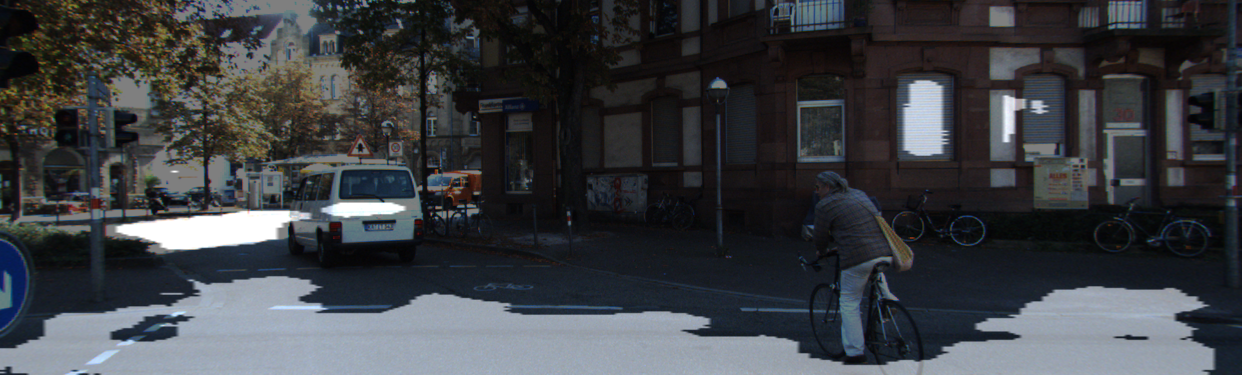

In [27]:
# i값을 바꾸면 테스트용 파일이 달라진다.
i = 2
print("U-Net")
get_output(
    unet_model,
    test_preproc,
    image_path = dir_path + f"/image_2/00{str(i).zfill(4)}_10.png",
    output_path = dir_path + f"./result_{str(i).zfill(3)}.png"
)

U-Net++


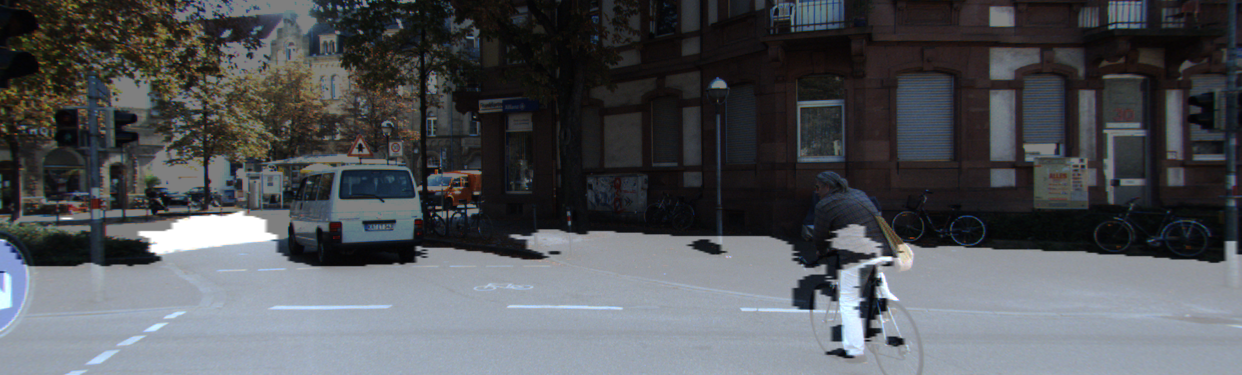

In [28]:
print("U-Net++")
get_output(
    unet_pp_model,
    test_preproc,
    image_path = dir_path + f"/image_2/00{str(i).zfill(4)}_10.png",
    output_path = dir_path + f"./result_{str(i).zfill(3)}.png",
)

### IoU로 추론하기.
IoU를 계산하려면 모델이 도로 영역이라 판단한 부분이 1, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 0으로 표시된 행렬이 필요하다. 

In [29]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print("IoU : %f" % iou_score)
    return iou_score

In [30]:
def iou_get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### 결과 확인하기



In [31]:
# i값을 바꾸면 테스트용 파일이 달라집니다. 
i = 2
print("U-Net")
output, prediction, target = iou_get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

U-Net
IoU : 0.584087


0.5840873634945398

In [32]:
print("U-Net++")
output, prediction, target = iou_get_output(
     unet_pp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

U-Net++
IoU : 0.635416


0.6354160668010366

In [34]:
for i in range(10):
    output, prediction, target = iou_get_output(
        unet_model, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )
    print("U-Net")
    print(calculate_iou_score(target, prediction))

    output, prediction, target = iou_get_output(
        unet_pp_model, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )
    print("U-Net++")
    print(calculate_iou_score(target, prediction))
    print("------------")

U-Net
IoU : 0.169192
0.1691919191919192
U-Net++
IoU : 0.902172
0.9021722021092398
------------
U-Net
IoU : 0.419641
0.41964089410040306
U-Net++
IoU : 0.882640
0.8826395357168446
------------
U-Net
IoU : 0.584087
0.5840873634945398
U-Net++
IoU : 0.635416
0.6354160668010366
------------
U-Net
IoU : 0.571212
0.5712116368286445
U-Net++
IoU : 0.530961
0.5309613163972287
------------
U-Net
IoU : 0.560296
0.5602958516454069
U-Net++
IoU : 0.694812
0.6948124303578062
------------
U-Net
IoU : 0.647032
0.6470318061775175
U-Net++
IoU : 0.748179
0.7481788495352927
------------
U-Net
IoU : 0.096767
0.09676714722586283
U-Net++
IoU : 0.654853
0.6548526001987413
------------
U-Net
IoU : 0.682226
0.6822262118491921
U-Net++
IoU : 0.848812
0.8488124126774027
------------
U-Net
IoU : 0.382736
0.3827360245934795
U-Net++
IoU : 0.830823
0.830823088821949
------------
U-Net
IoU : 0.417902
0.4179015612595925
U-Net++
IoU : 0.822679
0.8226790876967556
------------


# 최종 정리

|i|1|2|3|4|5|6|7|8|9|10|
|-|-|-|-|-|-|-|-|-|-|-|
|U-Net|0.169|0.419|0.584|0.571|0.560|0.647|0.096|0.682|0.382|0.417|
|U-Net++|0.902|0.882|0.635|0.530|0.694|0.748|0.654|0.848|0.830|0.822|
|최종 결과|U-Net++|U-Net++|U-Net++|U-Net|U-Net++|U-Net++|U-Net++|U-Net++|U-Net++|U-Net++|

U-Net보다 U-Net++의 결과가 좋게 나왔다. 비율은 1:9

U-Net++ 모델을 만들때 dropout을 추가한 결과물보다 추가하지 않은 결과물이 더 좋게 나왔다.   
dropout을 적용한 결과물을 봤을 때, 대부분의 영역을 도로라고 체크하고 있었다. 이렇게 나온 결과물을 봐선 dropout을 너무 많이 적용해서 제대로 학습이 안됐음을 예상할 수 있었다. 에포크를 100번 돌렸는데 3-400번정도 학습 시킨다면 제대로 알 수 있지 않았을까 싶다.

U-Net++의 설계도 Loss 부분이 제대로 이해가 되지 않아 study에 사용한 binary_crossentropy를 적용했다. 이 부분은 학습이 더 필요해보인다.